<a href="https://colab.research.google.com/github/AMBehroozi/PINN-Flow/blob/master/PINN_1D_Heat_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Dear Dr. Shen**

I have prepared this Jupyter notebook to validate the syntax used in my previous code when using auto differentiation in PyTorch with PINNs. The notebook includes a 1D transient heat equation with initial and boundary conditions, solved via PINN. I have also included a validation step using finite difference to confirm the correctness of the results.\
Please take a look at the notebook.\
\
Thank you very much.\
**Mehdi**



---


---
## Problem Statement

We have been given a PDE: 

$$ \frac{\partial T}{\partial t} = 2\frac{\partial^2 u}{\partial t^2} $$

initial condition: $$T(x,0)=0.0$$

and 
boundary condition: $$T(0,t)=T(L,t)=1.0$$

- Independent variables:$$ x,t (input) $$
- Dependent variables:$$ u (outputs)  $$


\




---


---
\
We have to find out $T(x,t)$ for all $x$ in range $[0,L=1]$ and $t$ in range [0,1]




First, we solved the problem using PINN, and then we compared the obtained results with those obtained from the finite difference method.

# Physics informed neural network

Epoch [500/3000], Loss: 0.11826541274785995
Epoch [1000/3000], Loss: 0.07262793928384781
Epoch [1500/3000], Loss: 0.06800071895122528
Epoch [2000/3000], Loss: 0.06632505357265472
Epoch [2500/3000], Loss: 0.06544288992881775
Epoch [3000/3000], Loss: 0.06485854089260101


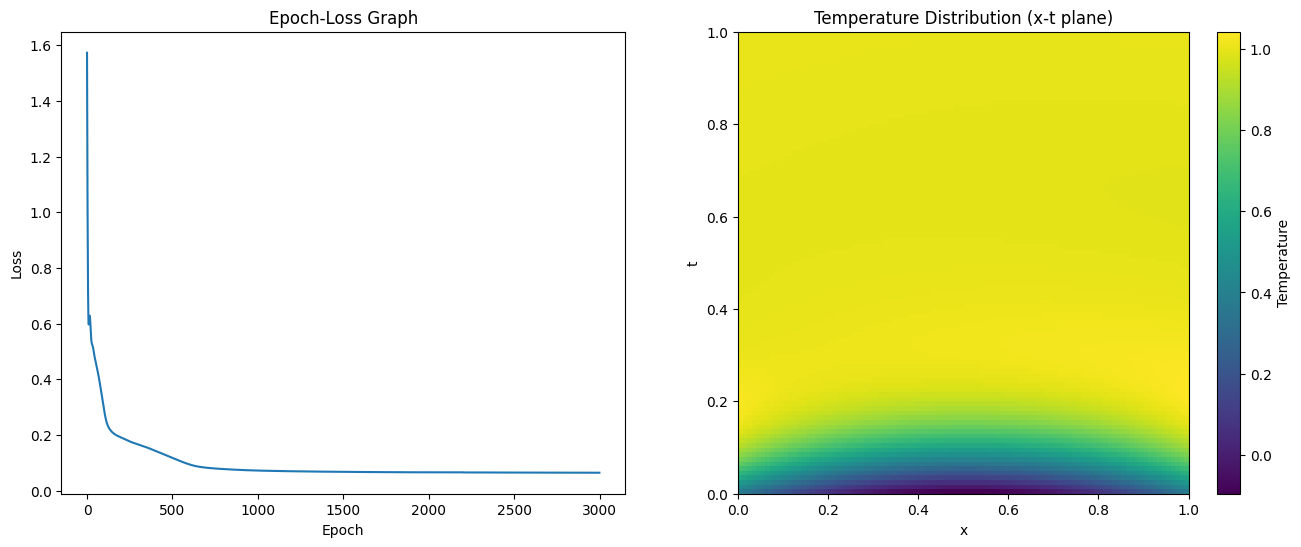

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the initial temperature distribution function for example at t=0 => f(x,t=0)=
def f(x):
    return 0.0

# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, num_hidden_layers, num_neurons):
        super(PINN, self).__init__()
        layers = [nn.Linear(2, num_neurons), nn.Tanh()]

        for _ in range(num_hidden_layers - 1):
            layers.extend([nn.Linear(num_neurons, num_neurons), nn.Tanh()])

        layers.append(nn.Linear(num_neurons, 1))
        self.layers = nn.Sequential(*layers)

    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        return self.layers(inputs)

# Loss functions
def boundary_condition(network, x_bc, t_bc):
  # T(0,t)=T(L,0)= 1.0
    T_bc = network(x_bc, t_bc)
    T_bc_target = torch.tensor([1.0]).repeat(x_bc.size(0), 1)
    return torch.mean((T_bc - T_bc_target) ** 2)

def initial_condition(network, x_ic, t_ic, f):
    T_ic = network(x_ic, t_ic)
    return torch.mean((T_ic - f(x_ic)) ** 2)

def loss_function(network, x, t, x_bc, t_bc, x_ic, t_ic, f):
    x.requires_grad_(True)
    t.requires_grad_(True)
    T = network(x, t)
    T_x = torch.autograd.grad(T.sum(), x, create_graph=True)[0]
    T_t = torch.autograd.grad(T.sum(), t, create_graph=True)[0]
    T_xx = torch.autograd.grad(T_x.sum(), x, create_graph=True)[0]

# The reason for using T.sum() instead of just T in the lines is 
# because torch.autograd.grad computes the gradients of a scalar function 
# with respect to the inputs. In our case, T is a tensor containing the 
# temperature values at different points in the x-t plane. 
# We want to compute partial derivatives with respect to x and t. 
# Using T.sum() is a workaround to compute the element-wise gradients for each 
# element in T with respect to x and t.
# By summing the tensor T, we create a scalar function, which allows us to use torch.autograd.grad. 
# The resulting gradients are still element-wise, as the gradient is computed for each element in T 
# with respect to the corresponding element in x and t.
# It is important to note that this approach assumes that the elements in T are 
# independent of each other, which is true in this case, 
# as each element in T corresponds to a unique combination of x and t.

    heat_equation = T_t - 2  * T_xx
    pde_loss = torch.mean((heat_equation) ** 2)
    bc_loss = boundary_condition(network, x_bc, t_bc)
    ic_loss = initial_condition(network, x_ic, t_ic, f)
    return pde_loss + bc_loss + ic_loss

# Create the neural network and optimizer
network = PINN(num_hidden_layers=2, num_neurons=50)

optimizer = optim.Adam(network.parameters(), lr=0.001)

# Training data
x = torch.linspace(0, 1, 100).view(-1, 1)
t = torch.linspace(0, 1, 100).view(-1, 1)
X, T = torch.meshgrid(x.squeeze(), t.squeeze())
X = X.reshape(-1, 1)
T = T.reshape(-1, 1)

# Boundary and initial conditions
x_bc = torch.tensor([0, 1]).view(-1, 1).repeat(10, 1)
t_bc = torch.linspace(0, 1, 10).view(-1, 1).repeat(1, 2).view(-1, 1)
x_ic = torch.linspace(0, 1, 100).view(-1, 1)
t_ic = torch.tensor([0]).view(1, -1).repeat(100, 1)

# Training loop
losses = []
num_epochs = 3000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(network, X, T, x_bc, t_bc, x_ic, t_ic, f)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
    
    losses.append(loss.item())

def plot_results(network, epochs):
    num_epochs = epochs
    with torch.no_grad():
        x_test = torch.linspace(0, 1, 100).view(-1, 1)
        t_test = torch.linspace(0, 1, 100).view(-1, 1)
        X_test, T_test = torch.meshgrid(x_test.squeeze(), t_test.squeeze())
        X_test = X_test.reshape(-1, 1)
        T_test = T_test.reshape(-1, 1)
        T_pred = network(X_test, T_test)
        T_pred = T_pred.view(100, 100).numpy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Epoch-Loss Graph
    ax1.plot(range(num_epochs), losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch-Loss Graph')

    # Plot Temperature Distribution (x-t plane)
    im = ax2.imshow(
        T_pred.T,
        interpolation="nearest",
        cmap="viridis",
        extent=[0, 1, 0, 1],
        origin="lower",
        aspect="auto",
    )
    fig.colorbar(im, ax=ax2, label="Temperature")
    ax2.set_xlabel("x")
    ax2.set_ylabel("t")
    ax2.set_title("Temperature Distribution (x-t plane)")

    plt.show()

plot_results(network, num_epochs)

# Finite Difference Method

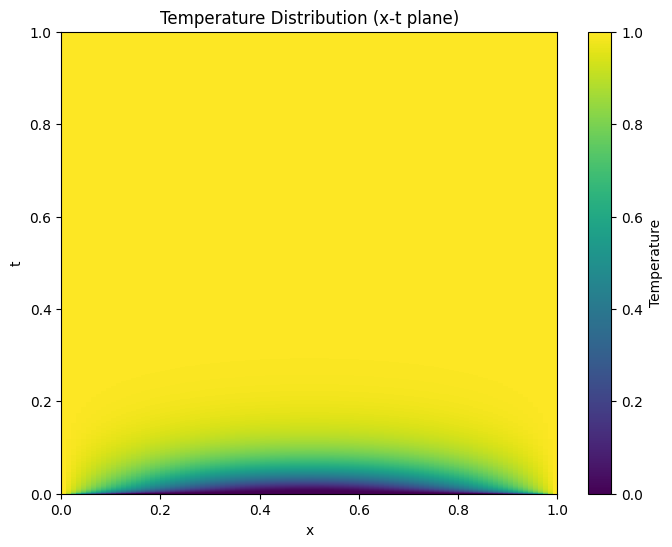

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0  # Length of the rod
alpha = 2.0  # Thermal diffusivity
N = 100  # Number of spatial points
T_final = 1.0  # Final time
dx = L / (N - 1)  # Spatial step size
dt = 0.5 * dx**2 / alpha  # Time step size based on CFL condition
M = int(T_final / dt) + 1  # Number of time steps

# Create mesh grid
x = np.linspace(0, L, N)
t = np.linspace(0, T_final, M)
X, T = np.meshgrid(t, x)

# Initialize temperature field
U = np.zeros((N, M))

# Set initial condition
U[:, 0] = 0.0

# Boundary conditions
U[0, :] = 1
U[-1, :] = 1

# Finite difference scheme
for n in range(0, M - 1):
    for i in range(1, N - 1):
        U[i, n + 1] = U[i, n] +  alpha * dt / dx**2 * (U[i + 1, n] - 2 * U[i, n] + U[i - 1, n])

# Plot the results
plt.figure(figsize=(8, 6))
plt.imshow(
    U.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[0, L, 0, T_final],
    origin="lower",
    aspect="auto",
)
plt.colorbar(label="Temperature")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Temperature Distribution (x-t plane)")
plt.show()


# In conclusion, I would like to express my deepest gratitude for your time and consideration.

Best regards,\
Mehdi